# Training a Compact Vision Transformer


This is it. You can now train a transformer on very limited data from scratch on very limited resources.

### CIFAR-10

We're going to use ``torchvision``'s CIFAR-10 dataset, which will automatically download it as well.

Its classes are: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


### Training an image classifier

We will do the following steps in order:

1. Download CIFAR-10 and load it
2. Clone the Compact Transformers repository from GitHub
3. Train the network on CIFAR-10
4. Load the trained checkpoint
5. Test the network on the test data

## 1. Loading the prerequisites

We need to import some basic requirements (PyTorch, Torchvision, and matplotlib).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

This function will plot images, their labels and the predicted labels (if specified). We'll use it as we go through.

In [2]:
def imshow(images, labels, predicted_labels=None):
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    # Inverting the normalization
    img = img.permute(1, 2, 0).mul(torch.tensor(cifar10_std))
    img += torch.tensor(cifar10_mean)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(6, 24))
    plt.imshow(img)

    if predicted_labels is not None:
        # Outputing the predicted labels
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=14)
    
    # Outputing the ground truth labels
    gax = ax.secondary_xaxis('top')
    gax.set_xlabel('Ground truth', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 35 + 20)
    gax.set_xticklabels([classes[labels[j]] 
                         for j in range(len(images))], fontsize=14)
    plt.show()

## 2. Loading and normalizing CIFAR10
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [3]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataiter = iter(trainloader)
test_dataiter = iter(testloader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


**Let's view some of the training images, for fun.** \\
Run this cell to see outputs. \\
You can run this cell multiple times.
Each run should return different images

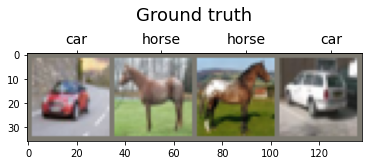

In [4]:
images, labels = dataiter.next()
imshow(images, labels)

## 3. Train CCT on CIFAR-10
We're going to clone the repository first.


In [5]:
from os import exists
if not exists("SOT-x-VIT"):
  !git clone https://github.com/tomkark/SOT-x-ViT.git
else:
    %cd SOT-x-ViT
    git pull
    cd ..

Cloning into 'SOT-x-ViT'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 83 (delta 21), reused 65 (delta 12), pack-reused 0
Unpacking objects: 100% (83/83), done.
/content/SOT-x-ViT
Branch 'modified-compact-transfomer' set up to track remote branch 'modified-compact-transfomer' from 'origin'.
Switched to a new branch 'modified-compact-transfomer'


We'll train $CCT-2/3\times2$ from the paper ( $\approx 280$ K parameters) for $30$ epochs. It should take around 10 minutes (may vary depending on which GPU Colab assigns to you).

Training is fairly simple,
we'll just run `main.py` with the the appropriate args.
The script will train and logs performance and time.

In [6]:
!python main.py \
       --model cct_2 \
       --conv-size 3 \
       --conv-layers 2 \
       --print-freq -1 \
       --epochs 30 \
       --workers 2 \
       ../cifar10

Files already downloaded and verified
Beginning training
[Epoch 1] 	 	 Top-1  32.59 	 	 Time: 0.54
Traceback (most recent call last):
  File "main.py", line 271, in <module>
    main()
  File "main.py", line 175, in main
    cls_train(train_loader, model, criterion, optimizer, epoch, args)
  File "main.py", line 215, in cls_train
    for i, (images, target) in enumerate(train_loader):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 681, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1359, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1325, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1163, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/usr/lib/python3.7/multiprocessin

## 4. Evaluation
Now we're going to load our trained transformer from file. \\
The script stores checkpoints in `checkpoint.pth`.

In [7]:
from src.cct import cct_2

transformer = cct_2(img_size=32,
                    num_classes=10,
                    positional_embedding='learnable',
                    n_conv_layers=2,
                    kernel_size=3)

transformer.load_state_dict(torch.load('checkpoint.pth'))

FileNotFoundError: ignored

**Okay, now let us see what the transformer thinks these examples above are:** \\
Run this cell to see outputs. \\
You can run this cell multiple times.
Each run should return different images

In [ ]:
images, labels = test_dataiter.next()

_, predicted = torch.max(transformer(images), 1)

imshow(images, labels, predicted)